# Tutorial PAMAP2 with mcfly

The goal of this tutorial is to get you familiar with training Neural Networks for time series using mcfly. At the end of the tutorial, you will have compared several Neural Network architectures you know how to train the best performing network.

As an example dataset we use the publicly available [PAMAP2 dataset](https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring). It contains time series data from movement sensors worn by nine individuals. The data is labelled with the activity types that these individuals did and the aim is to train and evaluate a *classifier*.

Before you can start, please make sure you install mcfly (see the [mcfly installation page](https://github.com/NLeSC/mcfly)).

## Import required Python modules

In [1]:
import sys
import os
import numpy as np
import pandas as pd
# mcfly
from mcfly import modelgen, find_architecture, storage
from keras.models import load_model
np.random.seed(2)

ModuleNotFoundError: No module named 'keras'

In [12]:
sys.path.insert(0, os.path.abspath('../..'))
from utils import tutorial_pamap2

## Download data pre-procesed data

We have created a function for you to fetch the preprocessed data from https://zenodo.org/record/834467. Please specify the `directory_to_extract_to` in the code below and then execute the cell. This will download the preprocessed data into the directory in the `data` subdirectory. The output of the function is the path where the preprocessed data was stored.

In [13]:
# Specify in which directory you want to store the data:
directory_to_extract_to = '.'

In [14]:
data_path = tutorial_pamap2.download_preprocessed_data(directory_to_extract_to)

Data already downloaded and extracted.


## A bit about the data

The [PAMAP2 dataset](https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring) contains data from three movement sensors worn by nine test subjects. These subjects performed a protocol of several activities.

The data originates from three sensors (on the hand, ankle and chest) and from each of the sensors we have three channels (acceleration on x, y and z axes). This gives us, for each time step, 9 values. The data is recorded on 100 Hz.

The preprocessed data is split into smaller segments with a window of 512 time steps, corresponding to 5.12 seconds. We only include segments that completely fall into one activity period: the activity is the *label* of the segment.

The goal of classification is to assign an activity label to an previously unseen segment.

## Load the pre-processed data

Load the preprocessed data as stored in Numpy-files. Please note that the data has already been split up in a training (training), validation (val), and test subsets. It is common practice to call the input data X and the labels y.

In [15]:
X_train, y_train_binary, X_val, y_val_binary, X_test, y_test_binary, labels = tutorial_pamap2.load_data(data_path)

Data X and labels y are of type Numpy array. In the cell below we inspect the shape of the data. As you can see the shape of X is expressed as a Python tuple containing: the number of samples, length of the time series, and the number of channels for each sample. Similarly, the shape of y is represents the number of samples and the number of classes (unique labels). Note that y has the format of a binary array where only the correct class for each sample is assigned a 1. This is called one-hot-encoding.

In [16]:
print('x shape:', X_train.shape)
print('y shape:', y_train_binary.shape)

x shape: (11397, 512, 9)
y shape: (11397, 7)


The data is split between train test and validation.

In [17]:
print('train set size:', X_train.shape)
print('validation set size:', X_val.shape[0])
print('test set size:', X_test.shape[0])

train set size: (11397, 512, 9)
validation set size: 100
test set size: 1000


Let's have a look at the distribution of the labels:

In [18]:
frequencies = y_train_binary.mean(axis=0)
frequencies_df = pd.DataFrame(frequencies, index=labels, columns=['frequency'])
frequencies_df

,frequency
lying,0.136615
sitting,0.130736
standing,0.136703
walking,0.176625
cycling,0.118540
vaccuum_cleaning,0.125208
ironing,0.175573


### *Question 1: How many channels does this dataset have?*
### *Question 2: What is the least common activity label in this dataset?*

    

## Generate models

First step in the development of any deep learning model is to create a model architecture. As we do not know what architecture is best for our data we will create a set of random models to investigate which architecture is most suitable for our data and classification task. This process, creating random models, checking how good they are and then selecting the best one is called a 'random search'. A random search is considered to be the most robust approach to finding a good model. You will need to specificy how many models you want to create with argument 'number_of_models'. See for a full overview of the optional arguments the function documentation of modelgen.generate_models by running `modelgen.generate_models?`.

##### What number of models to select?
This number differs per dataset. More models will give better results but it will take longer to evaluate them. For the purpose of this tutorial we recommend trying only 2 models to begin with. If you have enough time you can try a larger number of models, e.g. 10 or 20 models. Because mcfly uses random search, you will get better results when using more models.

In [19]:
num_classes = y_train_binary.shape[1]

models = modelgen.generate_models(X_train.shape,
                                  number_of_classes=num_classes,
                                  number_of_models = 2)

In [20]:
models

[(<keras.engine.sequential.Sequential at 0x7f84603dc940>,
  {'learning_rate': 0.08360289270402858,
   'regularization_rate': 0.0022439468517196116,
   'filters': array([85, 17, 44]),
   'fc_hidden_nodes': 443},
  'CNN'),
 (<keras.engine.sequential.Sequential at 0x7f84adebfb70>,
  {'learning_rate': 0.000893145093504032,
   'regularization_rate': 0.00319386451934688,
   'filters': [48, 43, 68, 77],
   'lstm_dims': [78]},
  'DeepConvLSTM')]

In [21]:
# Create resnet here (https://arxiv.org/pdf/1611.06455.pdf)
from keras import Input
from keras.layers import Convolution1D, Conv1D, BatchNormalization, ReLU, GlobalAvgPool1D, Softmax, Concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.regularizers import l2

weightinit = 'lecun_uniform'
regularization = 0

x = Input(shape=(X_train.shape[1:]))
inputs = x
def conv_bn_relu_3_sandwich(x, filters, kernel_size):
    first_x = x
    for i in range(3):
        x = Convolution1D(filters, kernel_size, padding='same', kernel_regularizer=l2(regularization))(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)    
    x = Concatenate()([x, first_x])
    return x
x = conv_bn_relu_3_sandwich(x, 64, 8)
x = conv_bn_relu_3_sandwich(x, 128, 5)
x = conv_bn_relu_3_sandwich(x, 128, 3)

##### Layer is not in paper: ##################
# Added to match filter number to label number
x = Convolution1D(y_train_binary.shape[1],1, kernel_regularizer=l2(regularization))(x)
###############################################

x = GlobalAvgPool1D()(x)
x = Softmax()(x)

predictions = x

outputs = x
model = Model(input=inputs, outputs=predictions)
wang_model = model
model.summary()
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=1e-4))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 9)       0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 512, 64)      4672        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 512, 64)      256         conv1d_7[0][0]                   
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 512, 64)      0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
conv1d_8 (

/home/christiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("so..., inputs=Tensor("in...)`


## Train the best model on the full dataset

Now that we have identified the best model architecture out of our random pool of models we can continue by training the model on the full training set.

This would take some time, so instead we will train  on only a slightly larger subset.

In [95]:
#We make a copy of the model, to start training from fresh
nr_epochs = 200
datasize = 100 # Change in `X_train.shape[0]` if training complete data set
history = wang_model.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              epochs=nr_epochs, validation_data=(X_val, y_val_binary))

Train on 100 samples, validate on 100 samples
Epoch 1/200
100/100 [==============================] - 12s 118ms/step - loss: 3.6300 - val_loss: 2.8957
Epoch 2/200
100/100 [==============================] - 3s 27ms/step - loss: 2.6852 - val_loss: 2.1054
Epoch 3/200
100/100 [==============================] - 3s 33ms/step - loss: 1.9921 - val_loss: 1.5476
Epoch 4/200
100/100 [==============================] - 3s 26ms/step - loss: 1.5572 - val_loss: 1.2160
Epoch 5/200
100/100 [==============================] - 3s 30ms/step - loss: 1.2995 - val_loss: 0.9815
Epoch 6/200
100/100 [==============================] - 3s 31ms/step - loss: 1.0078 - val_loss: 0.8186
Epoch 7/200
100/100 [==============================] - 3s 26ms/step - loss: 0.8196 - val_loss: 0.7163
Epoch 8/200
100/100 [==============================] - 3s 34ms/step - loss: 0.7796 - val_loss: 0.6419
Epoch 9/200
100/100 [==============================] - 3s 29ms/step - loss: 0.6659 - val_loss: 0.5901
Epoch 10/200
100/100 [============

100/100 [==============================] - 3s 35ms/step - loss: 0.0483 - val_loss: 1.2175
Epoch 160/200
100/100 [==============================] - 3s 29ms/step - loss: 0.0708 - val_loss: 1.1917
Epoch 161/200
100/100 [==============================] - 3s 32ms/step - loss: 0.0405 - val_loss: 1.1510
Epoch 162/200
100/100 [==============================] - 3s 33ms/step - loss: 0.0555 - val_loss: 1.1019
Epoch 163/200
100/100 [==============================] - 3s 27ms/step - loss: 0.0864 - val_loss: 1.0844
Epoch 164/200
100/100 [==============================] - 3s 32ms/step - loss: 0.1127 - val_loss: 1.1266
Epoch 165/200
100/100 [==============================] - 3s 30ms/step - loss: 0.0483 - val_loss: 1.1771
Epoch 166/200
100/100 [==============================] - 3s 29ms/step - loss: 0.1364 - val_loss: 1.1689
Epoch 167/200
100/100 [==============================] - 4s 35ms/step - loss: 0.1178 - val_loss: 1.1329
Epoch 168/200
100/100 [==============================] - 3s 28ms/step - loss: 

val_loss [2.8956511878967284, 2.1054317951202393, 1.547644352912903, 1.2159522342681885, 0.9815180206298828, 0.8186443471908569, 0.7163392972946167, 0.6418721461296082, 0.5900725603103638, 0.5509323930740356, 0.5232955050468445, 0.5054128432273864, 0.49534048318862917, 0.4915033483505249, 0.484206280708313, 0.46924701690673826, 0.4494542741775513, 0.4411033248901367, 0.44699023723602294, 0.4623290991783142, 0.4725939750671387, 0.49544501304626465, 0.5158901834487915, 0.5066285729408264, 0.5006854820251465, 0.4993626880645752, 0.5032028770446777, 0.4963810348510742, 0.4925814533233643, 0.5044474887847901, 0.5229779529571533, 0.5377362060546875, 0.5454844093322754, 0.5448711442947388, 0.5373769092559815, 0.5457673072814941, 0.567321138381958, 0.5954917430877685, 0.60868812084198, 0.6008945751190186, 0.6256803703308106, 0.6474853515625, 0.6583343887329102, 0.6940916967391968, 0.7210040664672852, 0.689592981338501, 0.6706331777572632, 0.6739588785171509, 0.681641960144043, 0.69155174255371

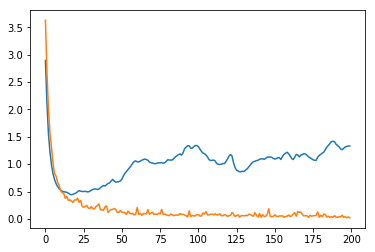

In [103]:
from matplotlib import pyplot as plt
%matplotlib inline
for h in history.history:
    print(h, history.history[h])
    plt.plot(history.history[h])


### *Question 7: Why does it take longer to train the best model for one epoch now than when we were  comparing model archicatures earlier on?*

### *Question 8: Do you think it is useful to train with more than 1 epoch?*

### Saving, loading and comparing reloaded model with original model

The model can be saved for future use. The savemodel function will save two separate files: a json file for the architecture and a npy (numpy array) file for the weights.

In [17]:
modelname = 'my_bestmodel.h5'
model_path = os.path.join(resultpath,modelname)

In [18]:
best_model.save(model_path)

In [19]:
model_reloaded = load_model(model_path)

The model has been reloaded. Let's reassure that this model has the same weights

In [20]:
np.all([np.all(x==y) for x,y in zip(best_model.get_weights(), model_reloaded.get_weights())])

True

## Investigate model predictions

We will now dive further into the Neural network that we created.
We provide here a network that has been trained on the complete train set.

In [71]:
# model = load_model('./model/model.h5')
model = wang_model

Note that the objects `models`, `best_model_fullytrained` and `best_model` that resulted from the mcfly functions are Keras objects. This means that you can use Keras functions on the objects, for example  `.predict`, (which when given the data, outputs the predictions for each sample) and `.evaluate` (which when given the data and the labels computes how well this model performs) . These functions are all documented in the [Keras documentation](https://keras.io/). 

In [73]:
## Inspect model predictions on validation data
datasize = X_val.shape[0]
probs = model.predict(X_val[:datasize,:,:],batch_size=1)

Let's have a look at the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

In [74]:
#columns are predicted, rows are truth
predicted = probs.argmax(axis=1)
y_index = y_val_binary.argmax(axis=1)
confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
confusion_matrix.index = [labels[i] for i in confusion_matrix.index]
confusion_matrix.columns = [labels[i] for i in confusion_matrix.columns]
confusion_matrix.reindex(columns=[l for l in labels], fill_value=0)
confusion_matrix

,lying,sitting,standing,walking,cycling,vaccuum_cleaning,ironing
lying,13,0,0,0,0,0,0
sitting,0,5,1,0,8,0,0
standing,0,0,19,0,0,1,0
walking,0,0,0,15,0,0,0
cycling,0,0,0,1,11,0,0
vaccuum_cleaning,0,0,0,0,0,8,0
ironing,0,0,0,0,6,2,10


In [77]:
## Test on Testset
score_test = models[0][0].evaluate(X_test, y_test_binary, verbose=True)
print('Score of best model: ' + str(score_test))

1000/1000 [==============================] - 32s 32ms/step
Score of best model: [2.3605376663208006, 0.503]


In [78]:
score_test = wang_model.evaluate(X_test, y_test_binary, verbose=True)
print('Score of best model: ' + str(score_test))

1000/1000 [==============================] - 7s 7ms/step
Score of best model: 1.2170636038780211
